In [ ]:
#bibliotecas
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

from matplotlib import pyplot as plt

In [ ]:
# Lendo dados;
train = pd.read_csv("../Databases/petr4_treinamento.csv")
test = pd.read_csv("../Databases/petr4_teste.csv")

### Pre-processamento

In [ ]:
# Retirando valoes vazios;
train = train.dropna()

# Separando o que queremos prever;
y_train = train.iloc[: , 1:2].values

# Preparando para normalizar o y_train;
normalizador = MinMaxScaler(feature_range=(0,1))
y_train = normalizador.fit_transform(y_train)


In [ ]:
# Preparando, será usado 90;
to_pred = []
data_real = []

for i in range(90, 1242):
    to_pred.append(y_train[i-90:i, 0])
    data_real.append(y_train[i, 0])

pred, real = np.array(to_pred), np.array(data_real)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1], 1))

del to_pred, data_real

### Criando camadas da rede neural

In [ ]:
def createNetwork():
    model = Sequential()
    # camada de entrada
    model.add(LSTM(units=100, return_sequences=True, input_shape = (pred.shape[1], 1)))
    model.add(Dropout(0.3))
    # Camada oculta 01;
    model.add(LSTM(units=80, return_sequences=True))
    model.add(Dropout(0.3))

    # Camada oculta 02;
    model.add(LSTM(units=80, return_sequences=True))
    model.add(Dropout(0.3))

    # Camada oculta 03;
    model.add(LSTM(units=80))
    model.add(Dropout(0.3))

    # Camada de saída;
    model.add(Dense(units=1, activation='linear'))

    # Configurando compile;
    model.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=["mean_squared_error"])

    return model

In [ ]:
# Treinando modelo
regressor = createNetwork()

regressor.fit(pred, real, epochs=100, batch_size= 50 )

### Trabalhando com dados de teste

In [ ]:
# Cocatenando dados de test e treino;
base = pd.concat((train["Open"], test["Open"]), axis=0)

# Fazendo split dos dados;
test = test.iloc[:, 1:2].values

# Ajustando a qunatidade necessaria de dasos para prever um mês;
base = base[len(base) - len(test) - 90:].values

# Realizando mudança de dimensionalidade;
base = base.reshape(-1,1)
# Normalizando dados;
base = normalizador.transform(base)


In [ ]:
# Fazendo divisão de amostra com tamanho 90;
X_test = []
for i in range(90, 112):
    X_test.append(base[i-90:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_test = regressor.predict(X_test)
pred_test = normalizador.inverse_transform(pred_test)

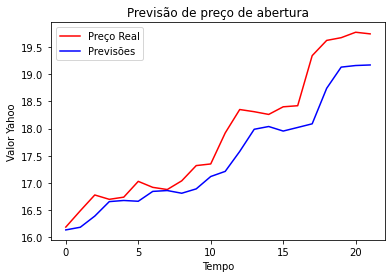

In [32]:
# Criando Grafico;
plt.plot(test, color="red", label="Preço Real" )
plt.plot(pred_test, color="blue", label="Previsões")
plt.title("Previsão de preço de abertura")
plt.xlabel("Tempo")
plt.ylabel("Valor Yahoo")
plt.legend()
plt.show();